In [1]:
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import sys
sys.path.append("../")
import analysis_util, tasks, general_network_visualization

AND experiment

In [26]:
data_path = "boolean_network_data/and_evolution_results/2023-03-13-21-10-14"
f_input_state = tasks.make_2_bit_input_state
f_eval = tasks.evaluate_and_task
input_nodes = [0, 1]
output_nodes = [2]

XOR experiment

In [27]:
data_path = "boolean_network_data/xor_evolution_results/2023-03-13-21-10-20"
f_input_state = tasks.make_2_bit_input_state
f_eval = tasks.evaluate_xor_task
input_nodes = [0, 1]
output_nodes = [2]

Shared AND experiment

In [89]:
data_path = "boolean_network_data/shared_and_evolution_results/2023-02-19-16-10-56"
f_input_state = tasks.make_3_bit_input_state
f_eval = tasks.evaluate_shared_and_task
input_nodes = [0, 1, 2]
output_nodes = [3, 4]

Sequential AND experiment

In [36]:
data_path = "boolean_network_data/sequential_and_evolution_results/2023-02-18-14-33-48/"
f_input_state = tasks.make_3_bit_input_state
f_eval = tasks.evaluate_sequential_and_task
input_nodes = [0, 1, 2]
output_nodes = [3, 4]

Parralel AND experiment

In [99]:
data_path = "boolean_network_data/parralel_and_evolution_results/converted_2023-03-22-18-16-14/"
f_input_state = tasks.make_4_bit_input_state
f_eval = tasks.evaluate_pnand_task
input_nodes = [0, 1, 2, 3]
output_nodes = [4, 5]

Parralel AND experiment (no noise)

In [91]:
data_path = "boolean_network_data/parralel_and_evolution_results/no_noise_2023-02-21-14-25-46/"
f_input_state = tasks.make_4_bit_input_state
f_eval = tasks.evaluate_pnand_task
input_nodes = [0, 1, 2, 3]
output_nodes = [4, 5]

In [100]:
data = np.load(os.path.join(os.getenv("DATA_DIR"), data_path, "batch_1.npz"))

In [101]:
N = data["N"]
input_state = cp.asnumpy(f_input_state(N))
best_functions = np.expand_dims(data["functions"], 1)
best_conn = np.expand_dims(data["connectivity"], 1)
best_used_conn = np.expand_dims(data["used_connectivity"], 1)
batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_state, 1), 1), (input_state.shape[0], np.shape(best_functions)[0], 1, N)).astype(np.bool_)

In [102]:
best_functions, best_conn, best_used_conn, sorted_perfs, _ =  analysis_util.sort_by_performance(cp.array(batched_input_state), cp.array(best_functions), cp.array(best_conn), cp.array(best_used_conn), f_eval, n_trajectories=int(10000/input_state.shape[0]))

In [103]:
graphs = [general_network_visualization.influence_graph_from_ragged_spec(f[0, :, :], c[0, :, :], uc[0, :, :]) for f, c, uc in zip(cp.asnumpy(best_functions), cp.asnumpy(best_conn), cp.asnumpy(best_used_conn))]
[g.remove_nodes_from(list(nx.isolates(g))) for g in graphs]
[general_network_visualization.prune_non_participating(g, input_nodes + output_nodes) for  g in graphs]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [108]:
%matplotlib tk
best_to_plot = 20
to_plot = graphs[:best_to_plot]
fig, axs = plt.subplots(ncols=len(to_plot), figsize=(12,5))
node_colors = ["C0"] * int(N)

for x in input_nodes:
    node_colors[x] = "C1"
for x in output_nodes:
    node_colors[x] = "C2"

positions = []
for i, (g, ax, err) in enumerate(zip(graphs, axs, sorted_perfs[:best_to_plot])):
    pos = nx.spring_layout(g, iterations=40)
    positions.append(pos)
    colorbar = True if i==best_to_plot-1 else False
    general_network_visualization.plot_network_directed(g, pos, ax, node_colors[:len(g.nodes)], colorbar=colorbar)
fig.tight_layout()

In [48]:
example_trajs, example_noise = analysis_util.run_dynamics_forward_save_state(cp.array(batched_input_state), best_functions, best_conn, best_used_conn, 7, 0.05)
example_trajs = np.squeeze(example_trajs, -2)
example_noise = np.squeeze(example_noise, -2)
example_trajs = cp.asnumpy(example_trajs)
example_noise = cp.asnumpy(example_noise)

In [49]:
fig, axs = plt.subplots(nrows=example_trajs.shape[1], ncols=best_to_plot, figsize=(15, 10))
for i in range(best_to_plot):
    for j in range(example_trajs.shape[1]):
        axs[j, i].pcolor(example_trajs[:, j, i, :], cmap="Greys", linewidth=0.3, edgecolors="black")
fig.tight_layout()

In [44]:
%matplotlib tk
traj_to_highlight = 0
fig, axs = plt.subplots(nrows=2, ncols=example_trajs.shape[1], sharey=True, sharex=True)
for j in range(example_trajs.shape[1]):
    axs[0, j].pcolor(example_trajs[:, j, 0, :], cmap="Greys", linewidth=0.2, edgecolors="black")
    axs[1, j].pcolor(np.pad(example_noise[:, j, 0, :], ((1,1), (0, 0))), cmap="Greys", linewidth=0.2, edgecolors="black")
    axs[1, j].set_xlabel("Node")
axs[0, 0].set_ylabel("Time")
axs[1, 0].set_ylabel("Time")

Text(0, 0.5, 'Time')

In [68]:
physical_error_rates = np.linspace(start=0, stop=0.01, num=20)
logical_error_rates = analysis_util.generate_ft_curve(physical_error_rates, cp.array(batched_input_state), cp.array(best_functions), cp.array(best_conn), cp.array(best_used_conn), f_eval, n_traj=5000)
logical_error_rates = cp.asnumpy(logical_error_rates)

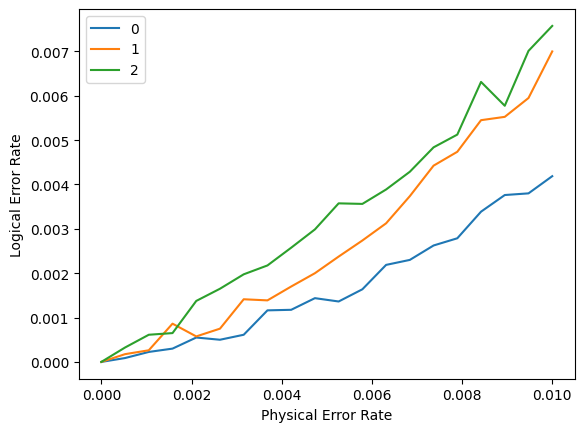

In [53]:
fig, axs = plt.subplots()
logical_error_rates = np.array(logical_error_rates)
for j in range(best_to_plot):
    axs.plot(physical_error_rates, logical_error_rates[:, j], label="{}".format(j))
axs.set_xlabel("Physical Error Rate")
axs.set_ylabel("Logical Error Rate")
axs.legend()


In [11]:
to_plot = 0
active_nodes = graphs[to_plot].nodes
possible_codewords = cp.asnumpy(example_trajs[-1, :, to_plot, active_nodes])
codewords = []
for codeword in possible_codewords.T:
    if not np.any([np.all(codeword == x) for x in codewords]):
        codewords.append(codeword)
codewords = np.stack(codewords)


In [12]:
%matplotlib tk
import importlib
importlib.reload(general_network_visualization)
fig, axs = plt.subplots(nrows=1, ncols=codewords.shape[0], figsize=(6,3))
for codeword, ax in zip(codewords, axs):
    general_network_visualization.plot_graph_with_state(graphs[to_plot], positions[to_plot], codeword, ax, ["yellow", "purple"], node_size=60)


In [17]:
np.sort(np.packbits(codewords, axis=0,bitorder="little"))


array([[1, 3, 3, 3, 4, 4, 4, 6, 6, 6, 6, 6, 6]], dtype=uint8)